# **Data Preparation**
- Select Data
- Clean Data
- Construct Data
- Format Data

---

## **Prepare Environment**

<br/>

### Imports

In [48]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # analise de variáveis vazia

# Other
import configparser
import subprocess
import warnings
import pprint
import time
import os

<br/>

### Prepare Principal Directory

In [49]:
def path_to_work(end_directory: str='notebooks'):
    curr_dir = os.path.dirname(os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Change directory to: {curr_dir}'
    
    return f'Current working directory: {curr_dir}'

In [50]:
path_to_work('notebooks')

'Current working directory: /home/campos/projects/data-analysis-of-spending-by-brazilian-senators'

<br/>

### Set Config

In [51]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## **Data Understanding**

### Collect Initial Data
- The data were collected from [Portal da transparência](https://www12.senado.leg.br/transparencia/dados-abertos-transparencia/dados-abertos-ceaps)
- **Years**: 2008 until 2021
- **Format**: CSV

### File Descriptions
- `despesas_ceaps_<YEAR>.csv` - dataset

<br/>

### Load Dataset

In [52]:
%%time

df = pd.read_csv('data/raw/despesa_ceaps_2021.csv', 
                 encoding='latin1',
                 delimiter=';', 
                 verbose=True)

Tokenization took: 19.52 ms
Type conversion took: 28.65 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 91.7 ms, sys: 3.59 ms, total: 95.3 ms
Wall time: 93.2 ms


<br/>



In [53]:
# hide_code

print("Dataframe:\n{} rows\n{} columns"
      .format(df.shape[0],
              df.shape[1]))

Dataframe:
15201 rows
2 columns


In [54]:
df.head(2)

,,,,,,,,,ULTIMA ATUALIZACAO,21/12/2021 02:00
ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
2021,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.",05.914.650/0001-66,ENERGISA,023.489.627,21/01/2021,Pagamento de energia elétrica para uso do escritório de apoio do Senador Acir Gurgacz,"75,29",2158003


**NOTES**
<br/>
- The data is not good formatted
- It is necessary remove the first row

Remove the 1ª row

In [55]:
%%time

df = pd.read_csv('data/raw/despesa_ceaps_2021.csv', 
                  encoding='latin1',
                  delimiter=';', 
                  header=1, # start df
                  verbose=True)

Tokenization took: 20.15 ms
Type conversion took: 32.08 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 60.3 ms, sys: 2.76 ms, total: 63 ms
Wall time: 61.9 ms


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15200 entries, 0 to 15199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ANO                15200 non-null  int64 
 1   MES                15200 non-null  int64 
 2   SENADOR            15200 non-null  object
 3   TIPO_DESPESA       15200 non-null  object
 4   CNPJ_CPF           15200 non-null  object
 5   FORNECEDOR         15200 non-null  object
 6   DOCUMENTO          14588 non-null  object
 7   DATA               15200 non-null  object
 8   DETALHAMENTO       8245 non-null   object
 9   VALOR_REEMBOLSADO  15200 non-null  object
 10  COD_DOCUMENTO      15200 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 1.3+ MB


**NOTES**
<br/>
- Os dados estão com formato de `;`
- Coluna `SENADOR` é o _target_
- Há 10 colunas
- 26691 linhas
- A data com maior número de pedido de reembolso foi 01/06/2016, por quê?
- Analisando as variáveis que temos para trabalhar é possível notar que será necessário converter algumas colunas de String para tipo numérico e assim conseguir aplicar alguma técnica de análise.
- É possível ter valores _missing_ pois nem todas as colunas tem o mesmo número de linhas.
- Analisar o SENADOR 90, pois é quem masi teve pedidos de reembolso nesse ano.

### Análise das Features
- `ANO(int64)`
- `MES(int64)`
- `SENADOR:` há 93 senadores
- `TIPO_DESPESA`: 7 tipos de dispesas diferentes
- `CNPJ_CPF(object)`: de quem prestou o serviço
- `FORNECEDOR`: há 4319 fornecedores diferentes
- `DOCUMENTO(object)`
- `DATA`: data da dispesa
- `DETALHAMENTO(object)`
- `VALOR_REEMBOLSADO`: valor reembolsado

<br/>

### **Explore Data**
First, let's explore what the column types are.

In [57]:
# Lists that will be manipulated in the data processing
list_columns = []
list_categorical_col = []
list_numerical_col = []

In [58]:
def get_col(df: pd.core.frame.DataFrame, type_descr: 'numpy') -> list:
    """
    Function get list columns 
    
    Args:
    type_descr
        np.number, np.object -> return list with all columns
        np.number            -> return list numerical columns 
        np.object            -> return list object columns
    """
    try:
        col = (df.describe(include=type_descr).columns) 
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n')    
    else:
        return col.tolist()

In [63]:
list_numerical_col = get_col(df=df,
                             type_descr=np.number)
list_categorical_col = get_col(df=df,
                               type_descr=np.object)
list_columns = get_col(df=df,
                       type_descr=[np.object, np.number])

<br/>

### Measure Location

In [60]:
def show_measures_location(df: pd.core.frame.DataFrame, type_descr: 'list') -> None:
    """
    Function get measures localization + total col + % type columns 
    Handler when type data not exists
    
    Args:
    type_descr
        np.number, np.object  -> return summary statistic with all columns
        np.number             -> return summary statistic numerical columns 
        np.object             -> return summary statistic object columns
    """
    try:
        col = (df.describe(include=type_descr).columns)  # pandas.core.indexes.base.Index  
    except ValueError:
        print(f'Dataframe not contains {type_descr} columns !', end='\n\n')    
    else:
        list_col = col.tolist()
        percentage = (len(list_col) / df.shape[1]) * 100
        
        print("-"*25, "MEASURES OF LOCALIZATION", "-"*25, end='\n\n')
        print(f"TOTAL columns {type_descr}: {len(list_col)}")
        print("PERCENTAGE {} in dataframe: {:3.4} %".format(type_descr, percentage))
        
        return df.describe(include=type_descr)

In [62]:
show_measures_location(df=df,
                       type_descr=[np.number, np.object])

------------------------- MEASURES OF LOCALIZATION -------------------------

TOTAL columns [<class 'numpy.number'>, <class 'object'>]: 11
PERCENTAGE [<class 'numpy.number'>, <class 'object'>] in dataframe: 100.0 %


,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
count,15200.00,15200.00,15200,15200,15200,15200,14588,15200,8245,15200,15200.00
unique,NaN,NaN,86,7,2626,2806,12980,396,5205,8083,NaN
top,NaN,NaN,JAQUES WAGNER,"Locomoção, hospedagem, alimentação, combustíve...",16.978.175/0001-08,ADRIA VIAGENS E TURISMO LTDA,S/N,01/07/2021,DESPESA COM COMBUSTÍVEL EM VEÍCULOS UTILIZADOS...,100,NaN
freq,NaN,NaN,624,5145,1024,432,48,128,442,412,NaN
mean,2021.00,6.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2163264.20
std,0.00,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4925.38
min,2021.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2154172.00
25%,2021.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159125.50
50%,2021.00,7.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2163336.50
75%,2021.00,9.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2167490.25


---

## **Data Preparation: Cleaning**

<br/>

### **Map Values**

#### Column: `SENADOR`
- senadores devem ser mapeados para valores numéricos

In [70]:
# Mapping (name)String in (number)integer

dict_map_senadores = {'senador_name': 'number'}
value = 0

for name in df['SENADOR']:
    
    if name in dict_map_senadores:
        dict_map_senadores[name] = value
    else:
        value += 1
        dict_map_senadores[name] = value

pp.pprint(dict_map_senadores)

{   'ACIR GURGACZ': 1,
    'ALESSANDRO VIEIRA': 2,
    'ALVARO DIAS': 3,
    'ANGELO CORONEL': 4,
    'ANTONIO ANASTASIA': 5,
    'CARLOS FÁVARO': 6,
    'CARLOS PORTINHO': 7,
    'CARLOS VIANA': 8,
    'CHICO RODRIGUES': 9,
    'CHIQUINHO FEITOSA': 10,
    'CID GOMES': 11,
    'CIRO NOGUEIRA': 12,
    'CONFÚCIO MOURA': 13,
    'DANIELLA RIBEIRO': 14,
    'DAVI ALCOLUMBRE': 16,
    'DÁRIO BERGER': 15,
    'EDUARDO BRAGA': 17,
    'EDUARDO GIRÃO': 18,
    'EDUARDO GOMES': 19,
    'ELIANE NOGUEIRA': 20,
    'ELIZIANE GAMA': 21,
    'ELMANO FÉRRER': 22,
    'ESPERIDIÃO AMIN': 23,
    'FABIANO CONTARATO': 24,
    'FERNANDO BEZERRA COELHO': 25,
    'FERNANDO COLLOR': 26,
    'FLÁVIO ARNS': 27,
    'FLÁVIO BOLSONARO': 28,
    'GIORDANO': 29,
    'HUMBERTO COSTA': 30,
    'IRAJÁ': 31,
    'IZALCI LUCAS': 32,
    'JADER BARBALHO': 33,
    'JAQUES WAGNER': 34,
    'JARBAS VASCONCELOS': 35,
    'JAYME CAMPOS': 36,
    'JEAN PAUL PRATES': 37,
    'JORGINHO MELLO': 38,
    'JOSÉ ANÍBAL': 39,
    '

In [71]:
%%time

# Replace dictionary in collumn SENADOR
df['SENADOR'] = df['SENADOR'].map(dict_map_senadores)

CPU times: user 4.35 ms, sys: 70 µs, total: 4.42 ms
Wall time: 3.76 ms


In [72]:
df.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2021,1,1,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,023.489.627,21/01/2021,Pagamento de energia elétrica para uso do escr...,"75,29",2158003


In [73]:
df.tail(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
15199,2021,11,86,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,JASTUN,25/11/2021,"Companhia Aérea: GOL, Localizador: JASTUN. Pas...","2522,85",2170571


#### Column: `CNPJ_CPF`

In [74]:
# Mapping (name)String in (number)integer

dict_map_cnpj_cpf = {'CNPJ_CPF': 'number'}
value = 0

for name in df['CNPJ_CPF']:
    
    if name in dict_map_cnpj_cpf:
        dict_map_cnpj_cpf[name] = value
    else:
        value += 1
        dict_map_cnpj_cpf[name] = value

In [75]:
%%time

# Replace dictionary in collumn SENADOR
df['CNPJ_CPF'] = df['CNPJ_CPF'].map(dict_map_cnpj_cpf)

CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 3.34 ms


#### Column: `FORNECEDOR`

In [76]:
# Mapping (name)String in (number)integer

dict_map_fornecedor = {'FORNECEDOR': 'number'}
value = 0

for name in df['FORNECEDOR']:
    
    if name in dict_map_fornecedor:
        dict_map_fornecedor[name] = value
    else:
        value += 1
        dict_map_fornecedor[name] = value

In [77]:
%%time

# Replace dictionary in collumn SENADOR
df['FORNECEDOR'] = df['FORNECEDOR'].map(dict_map_fornecedor)

CPU times: user 2.85 ms, sys: 708 µs, total: 3.55 ms
Wall time: 3.35 ms


#### Column: `TIPO_DESPESA`
- `TIPO_DESPESA` deve ter Strings menores
- Será mapeado

In [78]:
print(df['TIPO_DESPESA'].unique())

['Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.'
 'Divulgação da atividade parlamentar'
 'Passagens aéreas, aquáticas e terrestres nacionais'
 'Locomoção, hospedagem, alimentação, combustíveis e lubrificantes'
 'Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar'
 'Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos. '
 'Serviços de Segurança Privada']


In [79]:
# Mapping new values to collumn 'TIPO_DESPESA'

df['TIPO_DESPESA'] = df['TIPO_DESPESA'].map({'Aluguel de imóveis para escritório político, compreendendo despesas concernentes a eles.': 'Aluguel',
                                             'Aquisição de material de consumo para uso no escritório político, inclusive aquisição ou locação de software, despesas postais, aquisição de publicações, locação de móveis e de equipamentos. ': 'Despesas gerais',
                                             'Contratação de consultorias, assessorias, pesquisas, trabalhos técnicos e outros serviços de apoio ao exercício do mandato parlamentar': 'Contratações',
                                             'Locomoção, hospedagem, alimentação, combustíveis e lubrificantes': 'Locomoção, hospedagem e alimentação',
                                             'Passagens aéreas, aquáticas e terrestres nacionais': 'Passagens',
                                             'Divulgação da atividade parlamentar': 'Divulgação',
                                             'Serviços de Segurança Privada': 'Segurança'})

In [80]:
df.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2021,1,1,Aluguel,1795,529,023.489.627,21/01/2021,Pagamento de energia elétrica para uso do escr...,"75,29",2158003


#### Column: `VALOR_REEMBOLSADO`
- Esta com o padrão `,`, para trabalhar com os dados é melhor deixar no padrão `.`

In [81]:
df['VALOR_REEMBOLSADO'].head()

0    75,29
1     1000
2     6000
3     1500
4     6000
Name: VALOR_REEMBOLSADO, dtype: object

In [82]:
df['VALOR_REEMBOLSADO'] = df['VALOR_REEMBOLSADO'].str.replace(',', '.')

In [83]:
df.head(1)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2021,1,1,Aluguel,1795,529,023.489.627,21/01/2021,Pagamento de energia elétrica para uso do escr...,75.29,2158003


#### Column: `DATA`
- Checar possíveis preenchimento inconsistentes.

In [84]:
for row in df['DATA']:
    if (row < '*2020') is True and (row >'*2022'):
        print(row)

<br/>

### Check Unique Values

In [114]:
values_unique = df.nunique()
print(values_unique)

ANO                      1
MES                     12
SENADOR                 86
TIPO_DESPESA             7
CNPJ_CPF              1552
FORNECEDOR            1644
DOCUMENTO            12980
DATA                   396
DETALHAMENTO          5205
VALOR_REEMBOLSADO     8083
COD_DOCUMENTO        15200
dtype: int64


<br/>

### **Verify Data Quality**
- Check index
- Check for missing values
- Check for missing data in the cells
- Check for duplicate values
- Check for irrelevant values
- Check for outliers

<br/>

### Check Index

In [85]:
df.index

RangeIndex(start=0, stop=15200, step=1)

**NOTE**
<br/>
- The dataset has no missing index values, so there are no missing lines.

<br/>

### Remove id (index)

In [86]:
df.columns

Index(['ANO', 'MES', 'SENADOR', 'TIPO_DESPESA', 'CNPJ_CPF', 'FORNECEDOR',
       'DOCUMENTO', 'DATA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO',
       'COD_DOCUMENTO'],
      dtype='object')

**NOTE**
<br/>
This dataset not contains ID column

In [88]:
dict_cat_unique = generate_cat_unique_by_col(df, 
                                             *list_columns)
# pp.pprint(dict_cat_unique)

------------------------- Dictionary with Values Map by Column -------------------------



<br/>

### Missing Values

**ASK:** "Dados faltantes é porque não foi gravado ou porque não existe?"<br/>
Para responder essa questão é necessário analisar os _missing values_..

In [89]:
# return TRUE if collumn contains values missing

missing = df.isnull().any()
print(missing)

ANO                  False
MES                  False
SENADOR              False
TIPO_DESPESA         False
CNPJ_CPF             False
FORNECEDOR           False
DOCUMENTO             True
DATA                 False
DETALHAMENTO          True
VALOR_REEMBOLSADO    False
COD_DOCUMENTO        False
dtype: bool


In [90]:
# isnull()

def check_if_contains_missing_val(df: pd.core.frame.DataFrame):
    """
    Return TRUE, if collumn contains values missing
    """
    list_columns_missing = []
    
    for index, value in enumerate(df.isnull().any()):
        if value is True:
            list_columns_missing.append(df.columns[index])
    
    if len(list_columns_missing) > 0:
        print("Columns's name with missing values:")
        return list_columns_missing   
    
    print("The dataframe NOT contains missing values.")
    return 0

In [91]:
list_columns_m_v = check_if_contains_missing_val(df)

display(list_columns_m_v)  # display show one column by line

Columns's name with missing values:


['DOCUMENTO', 'DETALHAMENTO']

In [92]:
def check_quat_missing_data(df: pd.core.frame.DataFrame, columns_m_v: list) -> None:
    """
    Check if contains missing data
    Mark missing, if line contains NaN in any column
    """    
    if len(columns_m_v) > 0:
        missing_values_count = df.isnull().sum()
        total_missing = missing_values_count.sum()
        total_lines = df.shape[0]
        total_cells = np.product(df.shape)

        percentage_by_line = (total_missing/total_lines) * 100
        percentage_by_cell = (total_missing/total_cells) * 100

        # by column
        quant_missing_by_column = df[columns_m_v].isnull().sum()
        percentage_missing_by_column = (quant_missing_by_column/total_lines) * 100

        print("-"*25, "MISSING VALUES", "-"*25)
        print("\nSHAPE of data: {}".format(df.shape[0]))
        print("TOTAL missing values: {}".format(total_missing))
        print("TOTAL missing values by column:\n{}\n".format(quant_missing_by_column))

        print("PERCENTAGE missing values by row: {:2.3} %".format(percentage_by_line))
        print("PERCENTAGE missing values by cell: {:2.3} %".format(percentage_by_cell))
        print("PERCENTAGE missing values by column:\n{}".format(percentage_missing_by_column)) 

In [93]:
check_quat_missing_data(df, list_columns_m_v)

------------------------- MISSING VALUES -------------------------

SHAPE of data: 15200
TOTAL missing values: 7567
TOTAL missing values by column:
DOCUMENTO        612
DETALHAMENTO    6955
dtype: int64

PERCENTAGE missing values by row: 49.8 %
PERCENTAGE missing values by cell: 4.53 %
PERCENTAGE missing values by column:
DOCUMENTO       4.03
DETALHAMENTO   45.76
dtype: float64


#### Show Missing by Columns

<AxesSubplot:>

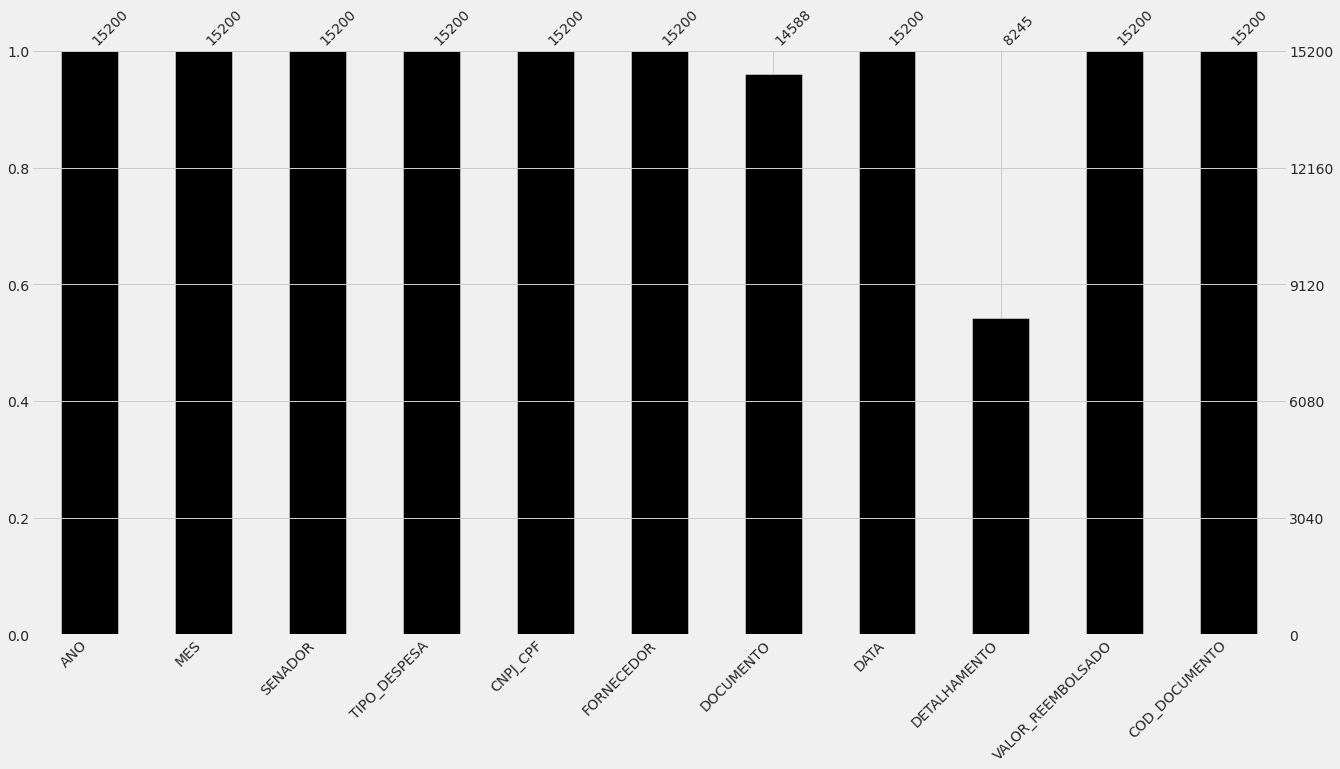

In [94]:
msno.bar(df,figsize=(20,10),fontsize=14,labels=True, color='black')

<AxesSubplot:>

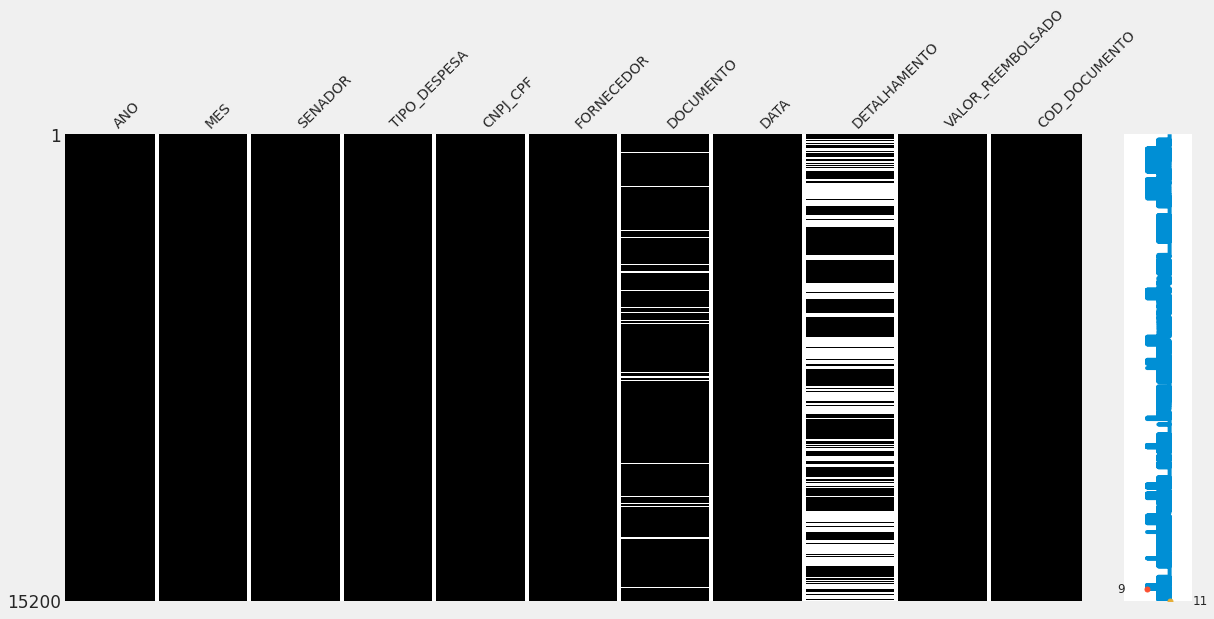

In [95]:
sorted_data = msno.nullity_sort(df)

msno.matrix(sorted_data,
            color=None,
            figsize=(18,8),
            fontsize=14)

#### Note
- Há vários _outliers_ que necessitam ser tratados individualmente
- Há valores preenchidos incorretamente e devem ser tratados 1 por 1
- _missing values_ são provindos da **falta de preenchimento**.
- Há poucos dados faltando, cerca de 2.7 %, por isso será utilizado a técnica de preencher com -1 os valores _missing_.

### Handling Missing Values
- tag: `missing` para valores categóricos 


In [96]:
df.fillna('MISSING', inplace=True)

In [97]:
df.query('DETALHAMENTO == "MISSING"').head(2)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
175,2021,1,2,Aluguel,40,39,853,15/01/2021,MISSING,500,2155145
176,2021,1,2,Aluguel,40,39,71943790582,09/03/2021,MISSING,3300,2156928


In [98]:
df.query('DOCUMENTO == "MISSING"').head(2)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
465,2021,1,5,Aluguel,89,90,MISSING,05/01/2021,MISSING,2347.37,2154179
466,2021,1,5,Aluguel,89,90,MISSING,11/01/2021,MISSING,5500,2154180


<br/>

### Duplicate Values

In [99]:
# duplicated()

def check_quat_duplicated_data(df: pd.core.frame.DataFrame) -> None:
    """
    Check if contains duplicated data
    Mark duplicates as ``True`` if enough row equal
    Except for the first occurrence.    
    """
    duplicated = df.duplicated().sum()
    total_lines = df.shape[0]
    percentage = (duplicated/total_lines) * 100
    
    print("-"*25, "DUPLICATED DATA", "-"*25,)
    print("\nSHAPE of data: {}".format(df.shape[0]))
    print("TOTAL duplicated data: {}".format(duplicated))
    print("PERCENTAGE duplicated data: {:3.2} %".format(percentage)) 

In [100]:
check_quat_duplicated_data(df)

------------------------- DUPLICATED DATA -------------------------

SHAPE of data: 15200
TOTAL duplicated data: 0
PERCENTAGE duplicated data: 0.0 %


In [101]:
# Create dataframe only duplicated values
df_duplicated_value = df[df.duplicated(keep=False)]

display(df_duplicated_value.head())

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO


#### Handling Duplicated Values

In [102]:
# drop_duplicates()

df = df.drop_duplicates(keep='first')
print("Shape dataframe = ", df.shape)

Shape dataframe =  (15200, 11)


<br/>

### Irrelavant Data

In [103]:
# I used the dictionary because they are more efficient in these cases
# https://stackoverflow.com/questions/22084338/pandas-dataframe-performance

def generate_cat_unique_by_col(df: pd.core.frame.DataFrame, *columns: list) -> dict:
    dict_unique = {}
    
    for column in columns:
        list_unique = df[column].unique().tolist()
        dict_column = {}
    
        for element in list_unique:
            if isinstance(element, float) is True:  # type nan is float
                continue
            dict_column[element] = int(list_unique.index(element))
        # add dict column in principal dict 
        dict_unique[column] = dict_column          
    
    print("-"*25, "Dictionary with Values Map by Column", "-"*25, end='\n\n')
    return dict_unique

<br/>

### **Types Convert**
- `VALOR_REEMBOLSADO` é do tipo object
- `DATA` é do tipo object
- `MES` pode ser menor
- `ANO` não é necessário
- `DATA` só importa o dia

#### Handler column: `ANO` 

In [104]:
df = df.drop(columns='ANO')

#### Types by Columns

In [105]:
df['MES'] = df['MES'].astype(dtype='int16', errors='raise')
df['SENADOR'] = df['SENADOR'].astype(dtype='int16', errors='raise')

df['TIPO_DESPESA'] = df['TIPO_DESPESA'].astype(dtype=str, errors='raise')
df['CNPJ_CPF'] = df['CNPJ_CPF'].astype(dtype='int16', errors='raise')
df['FORNECEDOR'] = df['FORNECEDOR'].astype(dtype='int16', errors='raise')
df['DOCUMENTO'] = df['DOCUMENTO'].astype(dtype=str, errors='raise')
df['DATA'] = pd.to_datetime(df['DATA'], errors='coerce')
df['DETALHAMENTO'] = df['DETALHAMENTO'].astype(dtype=str, errors='raise')

df['VALOR_REEMBOLSADO'] = pd.to_numeric(df['VALOR_REEMBOLSADO'])

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15200 entries, 0 to 15199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MES                15200 non-null  int16         
 1   SENADOR            15200 non-null  int16         
 2   TIPO_DESPESA       15200 non-null  object        
 3   CNPJ_CPF           15200 non-null  int16         
 4   FORNECEDOR         15200 non-null  int16         
 5   DOCUMENTO          15200 non-null  object        
 6   DATA               15199 non-null  datetime64[ns]
 7   DETALHAMENTO       15200 non-null  object        
 8   VALOR_REEMBOLSADO  15200 non-null  float64       
 9   COD_DOCUMENTO      15200 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int16(4), int64(1), object(3)
memory usage: 950.0+ KB


In [107]:
df.head(1)

,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,1,1,Aluguel,1795,529,023.489.627,2021-01-21,Pagamento de energia elétrica para uso do escr...,75.29,2158003


#### Handler column: `DATA`

In [108]:
df['DATA'] = df['DATA'].dt.strftime('%d')

In [109]:
df = df.rename(columns={'DATA': 'DIA'})

- Errors

In [110]:
dfb = df[df['DIA']=='NaT'].index
display(dfb)

Int64Index([], dtype='int64')

In [111]:
def fill_date(df: pd.core.frame.DataFrame, column):
    list_incosistence = df[df[column]=='NaT'].index

    for index in list_incosistence:
        df[column].loc[index] = 1

In [112]:
fill_date(df=df, column='DIA')

In [113]:
df.head(1)

,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DIA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,1,1,Aluguel,1795,529,023.489.627,21,Pagamento de energia elétrica para uso do escr...,75.29,2158003


In [114]:
# df['DIA'] = df['DIA'].astype(dtype='int16', errors='raise')

In [115]:
df['DIA'].dtypes

dtype('O')

#### Order by: `SENADOR`,`MES`, `DIA`

In [116]:
print(list_columns)

['ANO', 'MES', 'SENADOR', 'TIPO_DESPESA', 'CNPJ_CPF', 'FORNECEDOR', 'DOCUMENTO', 'DATA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO', 'COD_DOCUMENTO']


In [117]:
list_columns = ['DIA',
                'MES',
                'SENADOR',
                'TIPO_DESPESA',
                'CNPJ_CPF',
                'FORNECEDOR',
                'DOCUMENTO',
                'DETALHAMENTO',
                'VALOR_REEMBOLSADO']

In [118]:
df = df[list_columns].sort_values(by=['SENADOR','MES', 'DIA'])

In [119]:
df.head(15)

,DIA,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DETALHAMENTO,VALOR_REEMBOLSADO
1,01,1,1,Aluguel,19,19,01/2021,Despesa com pagamento de aluguel de imóvel par...,1000.00
2,01,1,1,Aluguel,22,22,001/21,Despesa com aluguel de imóvel para uso do escr...,6000.00
4,01,1,1,Divulgação,23,23,44,Divulgação da atividade parlamentar,6000.00
0,21,1,1,Aluguel,1795,529,023.489.627,Pagamento de energia elétrica para uso do escr...,75.29
5,21,1,1,Passagens,22,22,VVEWKR,"Companhia Aérea: LATAM, Localizador: VVEWKR. P...",1486.46
3,25,1,1,Divulgação,22,22,10,Divulgação da atividade parlamentar,1500.00
6,27,1,1,Passagens,22,22,FYJJRL,"Companhia Aérea: AZUL, Localizador: FYJJRL. Pa...",1890.00
9,02,2,1,Aluguel,19,19,02/2021,Despesa com aluguel de imóvel para uso do escr...,1000.00
10,02,2,1,Aluguel,22,22,002/21,Despesa com pagamento de aluguel de imóvel par...,6000.00
12,02,2,1,Divulgação,22,22,202100000000014,Despesa com divulgação da atividade parlamenta...,1500.00


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15200 entries, 1 to 15179
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DIA                15199 non-null  object 
 1   MES                15200 non-null  int16  
 2   SENADOR            15200 non-null  int16  
 3   TIPO_DESPESA       15200 non-null  object 
 4   CNPJ_CPF           15200 non-null  int16  
 5   FORNECEDOR         15200 non-null  int16  
 6   DOCUMENTO          15200 non-null  object 
 7   DETALHAMENTO       15200 non-null  object 
 8   VALOR_REEMBOLSADO  15200 non-null  float64
dtypes: float64(1), int16(4), object(4)
memory usage: 831.2+ KB


#### Update Columns

In [121]:
list_numerical_col = get_col(df=df,
                             type_descr=np.number)
list_categorical_col = get_col(df=df,
                               type_descr=np.object)
list_columns = get_col(df=df,
                       type_descr=[np.object, np.number])

**NOTE**
<br/>
Parece fazer sentido estes valores. Então se dará por concluido a parte de _data cleaning and data analisys_.

---

## **Save Clean Data**

In [122]:
df_map_senadores = pd.DataFrame.from_dict(dict_map_senadores, orient='index')
df_map_senadores.head()

,0
senador_name,number
ACIR GURGACZ,1
ALESSANDRO VIEIRA,2
ALVARO DIAS,3
ANGELO CORONEL,4


In [123]:
df_map_senadores = df_map_senadores.reset_index()
df_map_senadores = df_map_senadores.rename(columns={'index': 'senador_name'})

In [124]:
df_map_senadores = df_map_senadores.drop(index=0)

In [125]:
df_map_senadores.head()

,senador_name,0
1,ACIR GURGACZ,1
2,ALESSANDRO VIEIRA,2
3,ALVARO DIAS,3
4,ANGELO CORONEL,4
5,ANTONIO ANASTASIA,5


In [126]:
def save_data_clenning(df: pd.core.frame.DataFrame,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "saved data!"

In [127]:
save_data_clenning(df = df,
                   path = 'data/cleansing/dados_limpos_ceaps_cleansing.csv')

'saved data!'

In [128]:
save_data_clenning(df = df_map_senadores,
                   path = 'data/cleansing/map_senadores.csv')

'saved data!'

---